In [1]:
# Import packages and modules
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
plt.rcParams['axes.linewidth']=3

In [2]:
spec_dir = '/home/anirban/2020sck_tardis/Tardis_model_20210804/'

In [3]:
#=============================================================================
# Details of the object under study
# =============================================================================

Object = 'SN 2020sck'       
host = '2MASX J01103497+0206508'            
host_type = 'Host Galaxy'
Redshift = 0.017               # From https://www.wis-tns.org/object/2020sck
EB_V_Gal = 0.0256              # Only considering the Galaxy component  https://ned.ipac.caltech.edu/
EB_V_err_Gal = 0.0014          # Schlafly & Finkbeiner 2011
EB_V_Host = 0.00               # No Na-I D lines in HCT spectra observed
EB_V_err_Host = 0.00
JD_offset = 2459000
epoch = 2400000.5
RA = '01:10:34.841'            # https://www.wis-tns.org/object/2020sck
DEC = '+02:06:50.15'
Rv_MW = 3.1                    # The value of total-to-selective absorption
Rv_HG = 3.1
B_max = 2459098.841         # Calculated from spline, MLCS2k2 and SNooPy(E(B-V) model) 
DM = 34.24                     # http://leda.univ-lyon1.fr/ledacat.cgi?o=2MASX%20J01103497%2B0206508%20
DM_err = 0.22                  # 
dm15 = 2.03                    # Calculated from GP-fit
dm15_err = 0.05
z = 0.016

In [4]:
# Functions for File handling

def remove_file(file_name):
    """
    Removes the file 'file_name' in the constituent directory.
    Args:
         file_name  : Name of the file to be removed from the current directory
    Returns:
        None
    """
    try:
        os.remove(file_name)
    except OSError:
        pass
    
#-------------------------------------------------------------------------------#

def remove_similar_files(common_text):
    """
    Removes similar files based on the string 'common_text'.
    Args:
        common_text : String containing partial name of the files to be deleted
    Returns:
        None
    """
    for residual_file in glob.glob(common_text):
        remove_file(residual_file)
        
#-------------------------------------------------------------------------------#

def group_similar_files(text_list, common_text, exceptions=''):
    """
    Groups similar files based on the string 'common_text'. Writes the similar files
    onto the list 'text_list' (only if this string is not empty) and appends the similar
    files to a list 'python_list'.
    Args:
        text_list   : Name of the output text file with names grouped based on the 'common_text'
        common_text : String containing partial name of the files to be grouped
        exceptions  : String containing the partial name of the files that need to be excluded
    Returns:
        list_files  : Python list containing the names of the grouped files
    """
    list_files = glob.glob(common_text)
    if exceptions != '':
        list_exception = exceptions.split(',')
        for file_name in glob.glob(common_text):
            for text in list_exception:
                test = re.search(text, file_name)
                if test:
                    try:
                        list_files.remove(file_name)
                    except ValueError:
                        pass

    list_files.sort()
    if len(text_list) != 0:
        with open(text_list, 'w') as f:
            for file_name in list_files:
                f.write(file_name + '\n')

    return list_files

def smooth_1dspec(unsmoothed_df, sp = 2, kernel = 'gaussian', prefix_str = 'z_', plot = False):
    
    """
    Smoothens a 1-D spectra based on the smoothening parameter. Smoothening parameter
    is 'std.dev.' in case of isotropic Gaussian filter and is 'width' in the case of the
    non-isotropic box filter.
    Args:
        common_text : Common text of 1-D spectra files which have to be smoothened
        sp          : Smoothening parameter
        kernel      : Convolution Kernel used for smoothening (Gaussian or Box)
        prefix_str  : Prefix to distinguish the smoothened 1-D spectra from the original
        plot        : Boolean describing whether the smoothened spectra has to be plotted
    Returns:
        None
    """
    #for text in ['z_*.dat']:
    #    remove_similar_files(text)
    
    #list_spectra = group_similar_files('', common_text = common_text)
    usable_kernel = Gaussian1DKernel(int(sp), mode='oversample')
    
    if kernel.lower() != 'gaussian':
        if kernel.lower == 'box':
            usable_kernel = Box1DKernel(int(sp))
        else:
            print ("Error: Kernel '{0}' Not Recognised".format(kernel))
            sys.exit(1)
            
        #wave_data, flux_data = read_1dspec(file_name)
        #smoothed_data = convolve(flux_data, usable_kernel)
        #write_1dspec(ref_filename = file_name, flux_array = smoothed_data, prefix_str = prefix_str)
    #columns = ['Wave', 'Flux']
    #unsmoothed_df = pd.read_csv(file_name, sep='\s+', names=columns, engine='python')
        #print (type(unsmoothed_df['Flux'].values))
    smoothed_flux = convolve(unsmoothed_df['Flux'].values, usable_kernel)
    wave_array = unsmoothed_df['Wave'].values
    unsmoothed_flux = unsmoothed_df['Flux'].values
    smoothed_df = pd.DataFrame(list(zip(wave_array, smoothed_flux)), columns=['Wave', 'Flux'])
    smoothed_flux = smoothed_df['Flux'].values
        #smoothed_df.to_csv(prefix_str+file_name, sep=' ', index=None, header=['Wavelength', 'Flux'])
        
    if plot:
        plt.figure(figsize=(6,6))
        plt.plot(wave_array, unsmoothed_flux, 'g', label = 'Original Spectrum')
        plt.plot(wave_array, smoothed_flux, 'r--', label = 'Smooth Spectrum', alpha=0.5)
        plt.legend()
        plt.show()
        plt.close()
    
    return smoothed_df

#-------------------------------------------------------------------------------#

def cal_dist(dist_mod, dist_mod_err):
    
    '''
    Calculates distance and distance error
    
    dist_mod: Distance Modulus.
    dist_mod_err: Distance Modulus Error.
    
    '''
    
    d = (10**((dist_mod+5)/5))/10**6
    d_err = (2.303 * d * dist_mod_err)/5
    
    return [d, d_err]

#-------------------------------------------------------------------------------#

def flux_to_lum(flux, dist, dist_err):
    
    '''
    Calculate luminosity from flux value
    
    flux: flux value to be converted to luminosity.
    
    '''
    
    val_lum = float(flux) * 4 * np.pi * (3.086e24)**2
    luminosity = (val_lum)*cal_dist(dist, dist_err)[0]**2
    
    return luminosity

#-------------------------------------------------------------------------------#

def ejecta_mass(velocity_list, density_list):
    
    t_exp_sec = t_exp * 86400     # in secs
    const_Mej = (4*np.pi)/3
    M_ej = 0.0 
    for i in range(len(velocity_list)):
        if i < len(velocity_list)-1:
            M_ej += const_Mej * density_list[i] * (velocity_list[i]*t_exp_sec)**3
            
    M_sun = 1.989e33              # g
    norm_Mej = M_ej/M_sun         # in terms of solar mass
    #print (norm_Mej)
            
    return M_ej, norm_Mej

def plot_spectrum(spectrum_text_file, ml_x, mil_x, ml_y, mil_y):
    
    clip_str = '3300:9100'
    plt.rcParams['axes.linewidth']=2
    fig = plt.figure(figsize = (12,8))
    ax = fig.add_subplot(111)
    lower_limit, upper_limit = clip_str.split(':')

    data_df = pd.read_csv(spectrum_text_file, names = ['Wavelength', 'Flux'], sep = '\s+', dtype = 'float64')
    data_df = data_df[(data_df['Wavelength'] >= int(lower_limit)) & (data_df['Wavelength'] <= int(upper_limit))]
    data_df['Lum'] = data_df['Flux'].apply(lambda x: flux_to_lum(x, DM, DM_err))
    
    ax.xaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 12, width = 3.0, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 6, width = 1.5, labelsize = 20)
    ax.xaxis.set_major_locator(MultipleLocator(ml_x))
    ax.xaxis.set_minor_locator(MultipleLocator(mil_x))
    ax.yaxis.set_major_locator(MultipleLocator(ml_y))
    ax.yaxis.set_minor_locator(MultipleLocator(mil_y))
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize = 30)
                #tick.label1.set_fontweight('bold')
    
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize = 30)

    ax.plot(data_df['Wavelength'], data_df['Lum'], label = '_nolegend_', alpha = 1.0, 
           lw=2.0)
    
def plot_comp(filename, phase, name, redshift,
              clip_str = '3500:9200', apply_red = False):
    
    lower_clip, upper_clip = clip_str.split(':')
    
    df_read = pd.read_csv(filename, sep = '\s+', engine = 'python', comment = '#')
    #print df_read.shape[1]
    if df_read.shape[1] == 2:
        colnames = ['Wave', 'Flux']
        df = pd.read_csv(filename, sep = '\s+', engine = 'python', names = colnames, comment = '#')
        df = df[(df['Wave'] >= int(lower_clip)) & (df['Wave'] <= int(upper_clip))]
    elif df_read.shape[1] == 3:
        colnames = ['Wave', 'Flux', 'FluxErr']
        df = pd.read_csv(filename, sep = '\s+', engine = 'python', names = colnames, comment = '#')
        df = df[(df['Wave'] >= int(lower_clip)) & (df['Wave'] <= int(upper_clip))]
                

    df['LogFlux'] = df['Flux'].apply(lambda x: np.log10(x))

    if apply_red:
        df['Wave'] = df['Wave'].apply(lambda x: (1-redshift)*x)
    
    return df    
    
#-------------------------------------------------------------------------------#    
    
def plot_tardis_model(spectrum_text_file, tardis_file, tardis_file_1, tardis_file_2, tardis_file_3,
                      ml_x, mil_x, ml_y, mil_y):
    
    fig = plt.figure(figsize=(12,8))
    plt.rcParams['axes.linewidth']=2
    ax = fig.add_subplot(111)

    clip_str = '3700:9100'
    lower_limit, upper_limit = clip_str.split(':')
    
    data_df = pd.read_csv(spectrum_text_file, names = ['Wavelength', 'Flux'], sep = '\s+', dtype = 'float64')
    data_df = data_df[(data_df['Wavelength'] >= int(lower_limit)) & (data_df['Wavelength'] <= int(upper_limit))]
    data_df['Lum'] = data_df['Flux'].apply(lambda x: flux_to_lum(x, DM, DM_err))
    
    tardis_df = pd.read_csv(tardis_file, sep = '\s+', engine='python')
    tardis_df_1 = pd.read_csv(tardis_file_1, sep = '\s+', engine='python')
    tardis_df_2 = pd.read_csv(tardis_file_2, sep = '\s+', engine='python')
    tardis_df_3 = pd.read_csv(tardis_file_3, sep = '\s+', engine='python')
    
    
    df_hk = plot_comp(filename=spec_compare + '2005hk-0.8.dat', phase='-0.8', name='2005hk',
                redshift=0.012936, apply_red=True)
    smoothed_df_hk = smooth_1dspec(df_hk, sp=3)
    
    smoothed_df_hk['Lum'] = smoothed_df_hk['Flux'].apply(lambda x: flux_to_lum(x, 33.46, 0.01))
    
    
    ax.xaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 12, width = 3.0, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 6, width = 1.5, labelsize = 20)
    ax.xaxis.set_major_locator(MultipleLocator(ml_x))
    ax.xaxis.set_minor_locator(MultipleLocator(mil_x))
    ax.yaxis.set_major_locator(MultipleLocator(ml_y))
    ax.yaxis.set_minor_locator(MultipleLocator(mil_y))
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize = 30)
                #tick.label1.set_fontweight('bold')
    
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize = 30)
        
    ax.plot(data_df['Wavelength'], data_df['Lum'], alpha = 1.0, lw=2.0,
           color='red', label=r'$\rm SN~2020sck\ (+1.4\ d)$')
    ax.plot(tardis_df_1['Wave'], tardis_df_1['Lum'], 
            label=r'$TARDIS\ \rm model\ (E0.15$', ls='-', color='orange', lw=2.0)
    ax.plot(tardis_df_3['Wave'], tardis_df_3['Lum'], 
            label=r'$TARDIS\ \rm model\ (E0.20)$', ls='-', color='brown', lw=2.0)
    ax.plot(tardis_df_2['Wave'], tardis_df_2['Lum'], 
            label=r'$TARDIS\ \rm model\ (E0.22)$', ls='-', color='blue', lw=2.0)
    ax.plot(tardis_df['Wave'], tardis_df['Lum'], 
            label=r'$TARDIS\ \rm model\ (E0.25)$', ls='-', color='black', lw=2.0)
    ax.plot(smoothed_df_hk['Wave'], smoothed_df_hk['Lum'], 
            label=r'$\rm SN~2005hk\ (-0.8\ d)$', ls='-', color='green', lw=2.0)
    
    ax.legend(fontsize=23, borderaxespad=2.0)

    ax.set_xlabel(r'Wavelength [$\rm \AA$]', fontsize=27)
    ax.set_ylabel(r'Luminosity [erg/s/$\AA$]', fontsize=27)
    
#-------------------------------------------------------------------------------#    
    
def open_yaml(yaml_file):
    
    with open(tardis_yaml_file) as yaml_file:
        tardis_config = yaml.load(yaml_file, Loader=yaml.FullLoader)
        
        #for items, value in tardis_config.items():
        #    print (items, ':', value)
        
    return tardis_config

#-------------------------------------------------------------------------------#

In [5]:
smoothed_spectra_list = group_similar_files('', common_text=spec_dir+'z_dgr*.dat')


In [6]:
smoothed_spectra_list

['/home/anirban/2020sck_tardis/Tardis_model_20210804/z_dgrts2020-08-31_SN2020sck.dat',
 '/home/anirban/2020sck_tardis/Tardis_model_20210804/z_dgrts2020-09-07_SN2020sck.dat',
 '/home/anirban/2020sck_tardis/Tardis_model_20210804/z_dgrts2020-09-16_SN2020sck.dat']

In [7]:
tardis_spectrum_20200831_mixed =  spec_dir + 'tardis_n5def_modified_20200831.dat'
tardis_spectrum_20200831_N5 = spec_dir + 'tardis_n5def_20200831_.dat'
tardis_spectrum_20200907_mixed = spec_dir + 'tardis_n5def_mixed_20200907.dat'
tardis_spectrum_20200916_mixed_TiCr = spec_dir + 'tardis_n5def_mixed_20200916_newcomp.dat'
tardis_spectrum_20200916_mixed = spec_dir + 'tardis_n5def_mixed_20200916_newcomp_removeTiCr.dat'

In [8]:
dates_list = ['2020-08-31', '2020-09-07', '2020-09-16']

In [9]:
obs_spectrum_list = []

for spectra in smoothed_spectra_list:
    spectrum = spectra.split('/')[-1]
    for date in dates_list:
        if date in spectrum:
            obs_spectrum_list.append(spectrum)
            

In [10]:
obs_spectrum_list

['z_dgrts2020-08-31_SN2020sck.dat',
 'z_dgrts2020-09-07_SN2020sck.dat',
 'z_dgrts2020-09-16_SN2020sck.dat']

In [11]:
os.chdir(spec_dir)

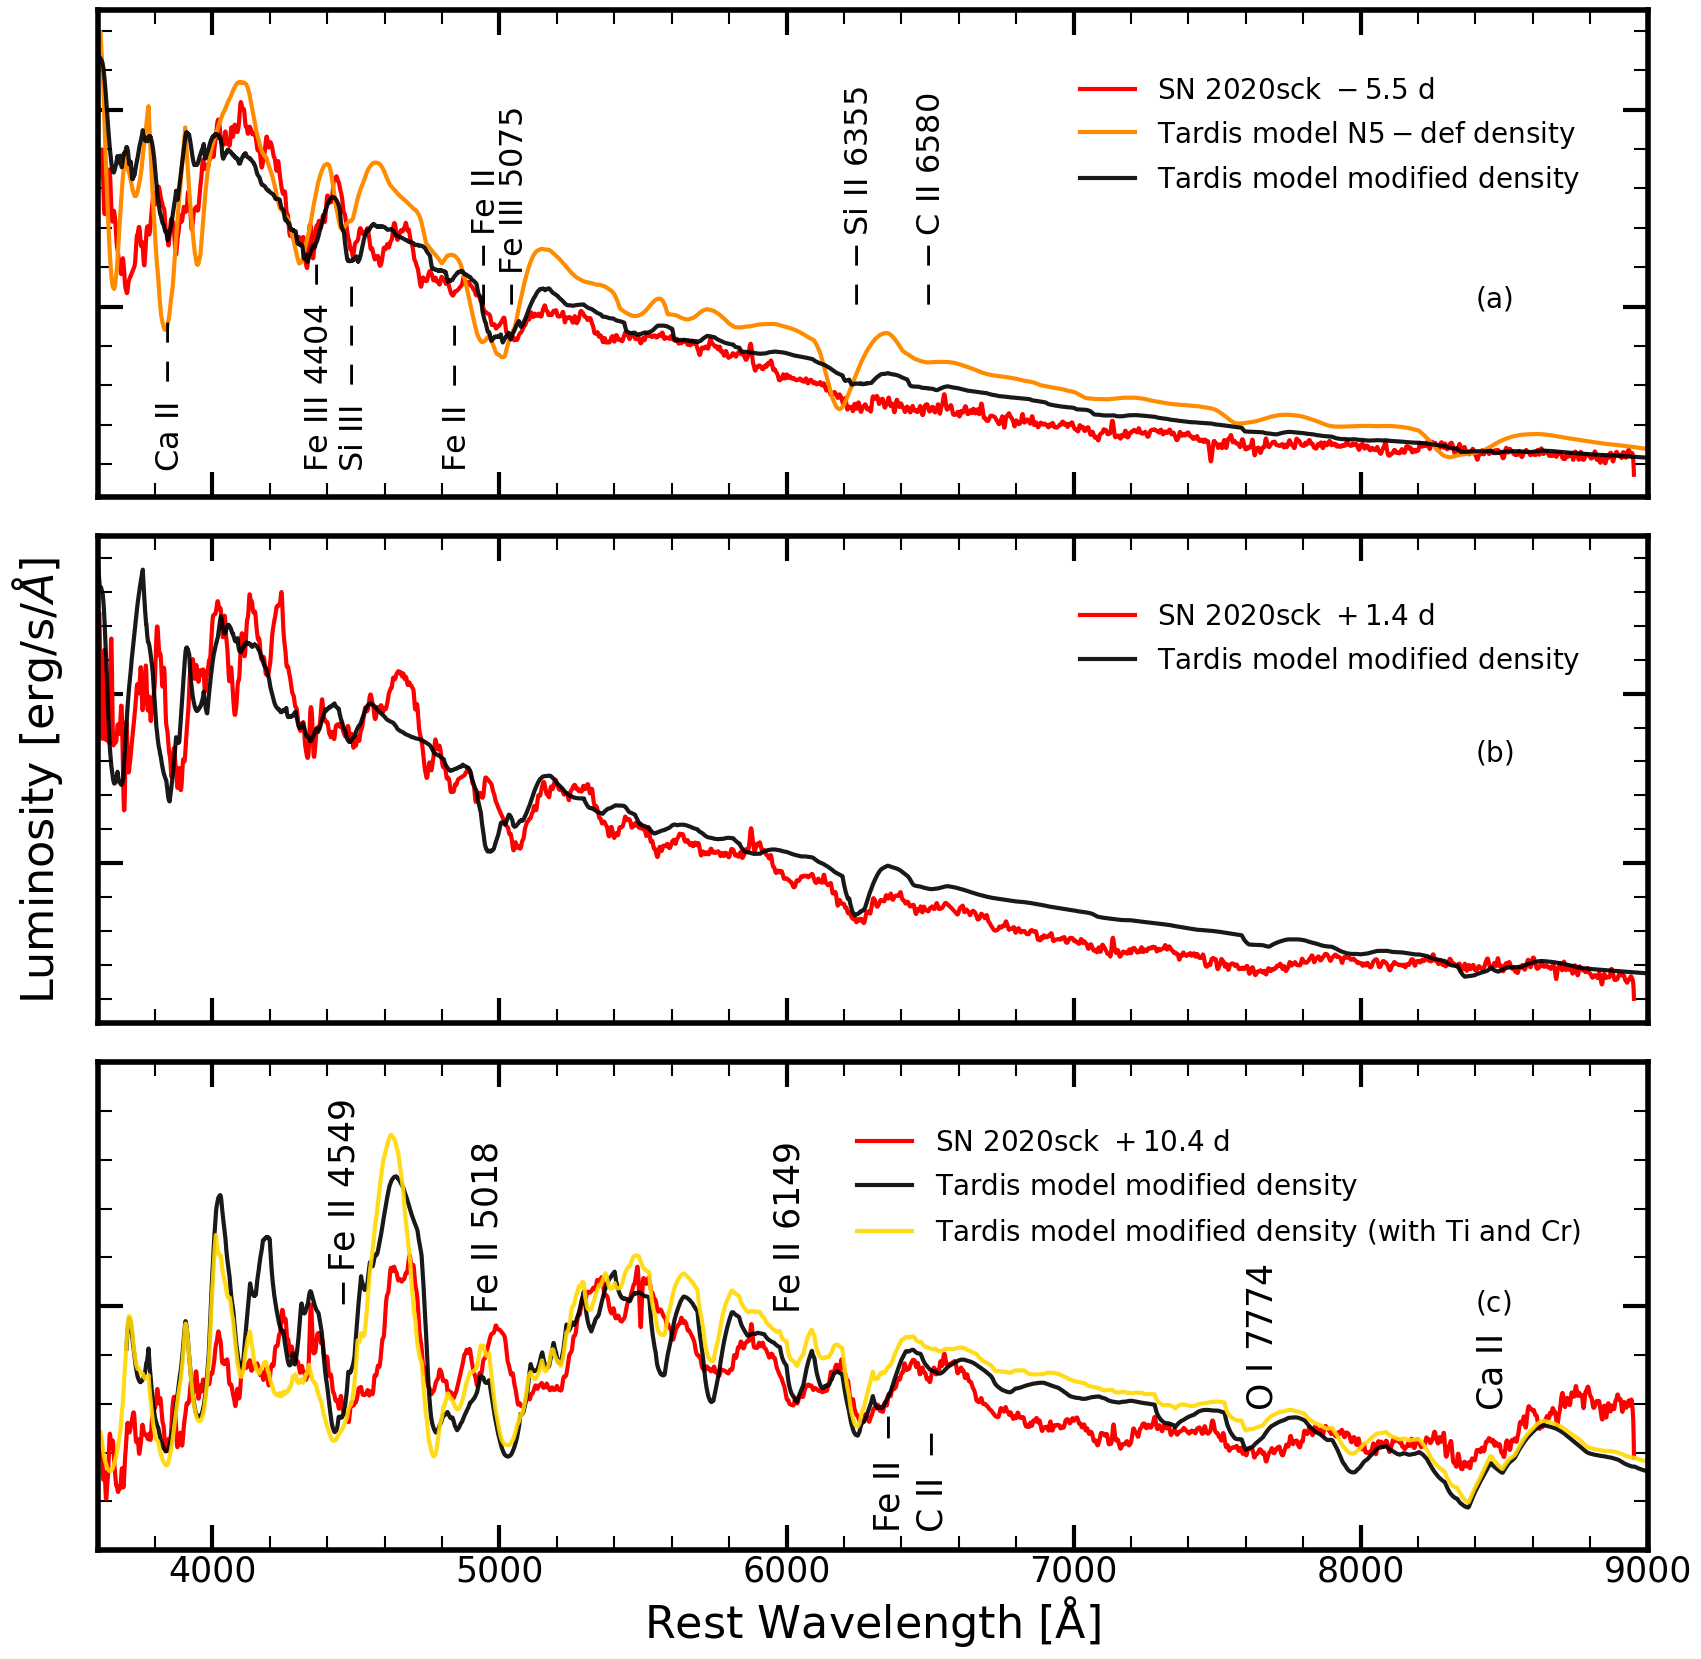

In [26]:
fig, ax = plt.subplots(3, sharex=True, figsize=(20, 20))
fig.subplots_adjust(hspace=0.08, wspace=0.1)
plt.rcParams['axes.linewidth'] = 4

clip_str = '3500:9100'
lower_limit, upper_limit = clip_str.split(':')
phase = ['-5.5', '+1.4', '+10.4']


obs_df_20200831 = pd.read_csv(obs_spectrum_list[0], sep='\s+', dtype='float64')
tardis_df_20200831_mixed = pd.read_csv(tardis_spectrum_20200831_mixed, sep='\s+', dtype='float64')
tardis_df_20200831_N5 = pd.read_csv(tardis_spectrum_20200831_N5, sep='\s+', dtype='float64')
obs_df_20200831 = obs_df_20200831[(obs_df_20200831['Wavelength'] >= int(lower_limit)) & (obs_df_20200831['Wavelength'] <= int(upper_limit))]
obs_df_20200831['Lum'] = obs_df_20200831['Flux'].apply(lambda x: flux_to_lum(x, DM, DM_err))

ax[0].plot(obs_df_20200831['Wavelength'], obs_df_20200831['Lum'], alpha = 1.0, lw=3.0,
           color='red', label=r'$\rm SN~2020sck\ -5.5\ d$')
ax[0].plot(tardis_df_20200831_N5['Wave'], tardis_df_20200831_N5['Lum'], alpha = 1.0, lw=3.0,
          color='darkorange', label=r'$\rm Tardis\ model\ N5-def\ density$')

ax[0].plot(tardis_df_20200831_mixed['Wave'], tardis_df_20200831_mixed['Lum'], 
                alpha = 0.9, lw=3.0, color='black', label=r'$\rm Tardis\ model\ modified\ density$')

ax[0].text(8400, 0.5e39, r'$\rm (a)$', fontsize=20)

dict_label = {1 : [r'$\rm Ca\ II\ --$', 3800, 0.1e39],
              2: [r'$\rm Fe\ III\ 4404\ -$', 4320, 0.1e39],
              3: [r'$\rm Si\ III\ ---$', 4440, 0.1e39],
              4: [r'$\rm Fe\ II\ --$', 4800, 0.1e39],
              5: [r'$\rm --Fe\ II $', 4900, 0.5e39],
              6: [r'$\rm -Fe\ III\ 5075$', 5000, 0.5e39],
              7: [r'$\rm --Si\ II\ 6355$', 6200, 0.5e39],
              8: [r'$\rm --C\ II\ 6580$', 6450, 0.5e39]}
             #9: [r'$\rm --Ca\ II\ $', 8400, -1.9e39]}
for (number, [line, wavelength, pos]) in dict_label.items():
    ax[0].text(wavelength, pos, line, fontsize = 23, rotation = 'vertical')    
    
ax[0].set_xlim(3500, 9000)    

#========================================================================================================#

obs_df_20200907 = pd.read_csv(obs_spectrum_list[1], sep='\s+', dtype='float64')
tardis_df_20200907_mixed = pd.read_csv(tardis_spectrum_20200907_mixed, sep='\s+', dtype='float64')
obs_df_20200907 = obs_df_20200907[(obs_df_20200907['Wavelength'] >= int(lower_limit)) & (obs_df_20200907['Wavelength'] <= int(upper_limit))]
obs_df_20200907['Lum'] = obs_df_20200907['Flux'].apply(lambda x: flux_to_lum(x, DM, DM_err))

ax[1].plot(obs_df_20200907['Wavelength'], obs_df_20200907['Lum'], alpha = 1.0, lw=3.0,
           color='red', label=r'$\rm SN~2020sck\ +1.4\ d$')

ax[1].plot(tardis_df_20200907_mixed['Wave'], tardis_df_20200907_mixed['Lum'], 
                alpha = 0.9, lw=3.0, color='black', label=r'$\rm Tardis\ model\ modified\ density$')

ax[1].text(8400, 0.8e39, r'$\rm (b)$', fontsize=20)

ax[1].set_xlim(3500, 9000)
#========================================================================================================#

obs_df_20200916 = pd.read_csv(obs_spectrum_list[2], sep='\s+', dtype='float64')
tardis_df_20200916_mixed = pd.read_csv(tardis_spectrum_20200916_mixed, sep='\s+', dtype='float64')
tardis_df_20200916_mixed = tardis_df_20200916_mixed[(tardis_df_20200916_mixed['Wave'] >=3700) & 
                                                    (tardis_df_20200916_mixed['Wave'] < 9000)]

tardis_df_20200916_TiCr = pd.read_csv(tardis_spectrum_20200916_mixed_TiCr, sep='\s+', dtype='float64')
obs_df_20200916 = obs_df_20200916[(obs_df_20200916['Wavelength'] >= int(lower_limit)) & (obs_df_20200916['Wavelength'] <= int(upper_limit))]
obs_df_20200916['Lum'] = obs_df_20200916['Flux'].apply(lambda x: flux_to_lum(x, DM, DM_err))

ax[2].plot(obs_df_20200916['Wavelength'], obs_df_20200916['Lum'], alpha = 1.0, lw=3.0,
           color='red', label=r'$\rm SN~2020sck\ +10.4\ d$')

ax[2].plot(tardis_df_20200916_mixed['Wave'], tardis_df_20200916_mixed['Lum'], 
                alpha = 0.9, lw=3.0, color='black', label=r'$\rm Tardis\ model\ modified\ density$')

ax[2].plot(tardis_df_20200916_TiCr['Wave'], tardis_df_20200916_TiCr['Lum'], 
           alpha=0.9, lw=3.0, color='gold', label=r'$\rm Tardis\ model\ modified\ density\ (with\ Ti\ and\ Cr)$')

ax[2].text(8400, 4.9e38, r'$\rm (c)$', fontsize=20)

dict_label = {1 : [r'$\rm -Fe\ II\ 4549$', 4400, 0.5e39], 
              2: [r'$\rm Fe\ II\ 5018\ $', 4900, 0.5e39], 
              3: [r'$\rm Fe\ II\ 6149$', 5950, 0.5e39],
              #4: [r'$\rm $', 6050, 0.5e39], 5: [r'$\rm Fe\ II\ 6247$', 6150, 0.5e39],
              6: [r'$\rm Fe\ II\ -$', 6300, 0.05e39], 
              7: [r'$\rm C\ II\ -$', 6450, 0.05e39],
              8: [r'$\rm O\ I\ 7774$', 7600, 0.3e39],
              9: [r'$\rm Ca\ II\ $', 8400, 0.3e39]}
for (number, [line, wavelength, pos]) in dict_label.items():
    ax[2].text(wavelength, pos, line, fontsize = 25, rotation = 'vertical')        
                

ax[2].set_xlim(3600, 9000)

'''

for index, file_name in enumerate(obs_spectrum_list, 1):
    obs_df = pd.read_csv(file_name, sep = '\s+', dtype = 'float64')
    obs_df = obs_df[(obs_df['Wavelength'] >= int(lower_limit)) & (obs_df['Wavelength'] <= int(upper_limit))]
    obs_df['Lum'] = obs_df['Flux'].apply(lambda x: flux_to_lum(x, DM, DM_err))
    
    if index == 3:
        ax[0].plot(obs_df['Wavelength'], obs_df['Lum'] - index*0.8e39, alpha = 1.0, lw=3.0,
           color='red')
        ax[0].text(x = 8000, y = obs_df['Lum'].values[-1] - index*0.74e39, 
            s = phase[index-1], fontsize = 30, rotation = 'horizontal', color='red')
    else:
        ax[0].plot(obs_df['Wavelength'], obs_df['Lum'] - index*0.8e39, alpha = 1.0, lw=3.0,
           color='red')
        ax[0].text(x = 8000, y = obs_df['Lum'].values[-1] - index*0.7e39, 
            s = phase[index-1], fontsize = 30, rotation = 'horizontal', color='red')
        
for index, file_name in enumerate(tardis_w7_spectra_list, 1):
    #print (index)
    tardis_w7_df = pd.read_csv(file_name, sep = '\s+', dtype = 'float64')
    if index == 3:
        ax[0].plot(tardis_w7_df['Wave'], tardis_w7_df['Lum'] - index*0.8e39, 
                alpha = 0.7, lw=3.0, color='darkcyan', label=r'$\rm W7\ (E0.25)$')
    else:
        ax[0].plot(tardis_w7_df['Wave'], tardis_w7_df['Lum'] - index*0.8e39, 
                alpha = 0.7, lw=3.0, color='darkcyan')    
        
for index, file_name in enumerate(obs_spectrum_list, 1):
    obs_df = pd.read_csv(file_name, sep = '\s+', dtype = 'float64')
    obs_df = obs_df[(obs_df['Wavelength'] >= int(lower_limit)) & (obs_df['Wavelength'] <= int(upper_limit))]
    obs_df['Lum'] = obs_df['Flux'].apply(lambda x: flux_to_lum(x, DM, DM_err))
    
    if index == 3:
        ax[1].plot(obs_df['Wavelength'], obs_df['Lum'] - index*0.8e39, alpha = 1.0, lw=3.0,
           color='red')
        ax[1].text(x = 8000, y = obs_df['Lum'].values[-1] - index*0.74e39, 
            s = phase[index-1], fontsize = 30, rotation = 'horizontal', color='red')
    else:
        ax[1].plot(obs_df['Wavelength'], obs_df['Lum'] - index*1e39, alpha = 1.0, lw=3.0,
           color='red')
        ax[1].text(x = 8000, y = obs_df['Lum'].values[-1] - index*0.9e39, 
            s = phase[index-1], fontsize = 30, rotation = 'horizontal', color='red')
        
dict_label = {1 : [r'$\rm -Fe\ II\ 4549$', 4400, -1.9e39], 
              2: [r'$\rm -Fe\ II\ 5018$', 4900, -1.9e39], 
              3: [r'$\rm --Fe\ II\ 6149$', 5950, -2.0e39],
              4: [r'$\rm -----$', 6050, -2.0e39], 5: [r'$\rm Fe\ II\ 6247$', 6150, -1.8e39],
              6: [r'$\rm --Fe\ II\ 6456$', 6300, -2.0e39], 
              7: [r'$\rm --C\ II\ 6578$', 6450, -2.0e39],
              8: [r'$\rm --O\ I\ 7774$', 7600, -2.1e39],
             9: [r'$\rm --Ca\ II\ $', 8400, -1.9e39]}
for (number, [line, wavelength, pos]) in dict_label.items():
    ax[0].text(wavelength, pos, line, fontsize = 25, rotation = 'vertical')        
                
        
for index, file_name in enumerate(tardis_spectrum_list, 1):
    #print (index)
    tardis_n5def_df = pd.read_csv(file_name, sep = '\s+', dtype = 'float64')
    if index == 3:
        ax[1].plot(tardis_n5def_df['Wave'], tardis_n5def_df['Lum'] - index*0.8e39, 
                alpha = 0.8, lw=3.0, color='royalblue', label=r'$\rm N5-def$')
    else:
        ax[1].plot(tardis_n5def_df['Wave'], tardis_n5def_df['Lum'] - index*1e39, 
                alpha = 0.8, lw=3.0, color='royalblue')   
        

for index, file_name in enumerate(obs_spectrum_list, 1):
    obs_df = pd.read_csv(file_name, sep = '\s+', dtype = 'float64')
    obs_df = obs_df[(obs_df['Wavelength'] >= int(lower_limit)) & (obs_df['Wavelength'] <= int(upper_limit))]
    obs_df['Lum'] = obs_df['Flux'].apply(lambda x: flux_to_lum(x, DM, DM_err))
    
    if index == 3:
        ax[2].plot(obs_df['Wavelength'], obs_df['Lum'] - index*0.8e39, alpha = 1.0, lw=3.0,
           color='red')
        ax[2].text(x = 8000, y = obs_df['Lum'].values[-1] - index*0.74e39, 
            s = phase[index-1], fontsize = 30, rotation = 'horizontal', color='red')
    else:
        ax[2].plot(obs_df['Wavelength'], obs_df['Lum'] - index*1e39, alpha = 1.0, lw=3.0,
           color='red')
        ax[2].text(x = 8000, y = obs_df['Lum'].values[-1] - index*0.9e39, 
            s = phase[index-1], fontsize = 30, rotation = 'horizontal', color='red')        
        
for index, file_name in enumerate(tardis_modified_spectrum_list, 1):
    #print (index)
    tardis_n5def_modified_df = pd.read_csv(file_name, sep = '\s+', dtype = 'float64')
    if index == 3:
        ax[2].plot(tardis_n5def_modified_df['Wave'], tardis_n5def_modified_df['Lum'] - index*0.8e39, 
                alpha = 0.8, lw=3.0, color='lime', label=r'$\rm N5-def\ (\rho \times 0.2)$')
    else:
        ax[2].plot(tardis_n5def_modified_df['Wave'], tardis_n5def_modified_df['Lum'] - index*1e39, 
                alpha = 0.8, lw=3.0, color='lime')           
        

'''
        
for i in range(len(ax)):
    #print (i)
    ax[i].yaxis.set_major_formatter(plt.NullFormatter())     
    ax[i].xaxis.set_ticks_position('both')
    ax[i].xaxis.set_ticks_position('both')
    ax[i].yaxis.set_ticks_position('both')
    ax[i].tick_params(axis = 'both', which = 'major', direction = 'in', length = 18, width = 3.0, labelsize = 20)
    ax[i].tick_params(axis = 'both', which = 'minor', direction = 'in', length = 10, width = 1.5, labelsize = 20)
    ax[i].xaxis.set_major_locator(MultipleLocator(1000))
    ax[i].xaxis.set_minor_locator(MultipleLocator(200))
    ax[i].yaxis.set_major_locator(MultipleLocator(0.5e39))
    ax[i].yaxis.set_minor_locator(MultipleLocator(0.1e39))    

    for tick in ax[i].xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize = 25)
    
    for tick in ax[i].yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize = 25)
    
    ax[i].legend(fontsize=20, borderaxespad=2.0, fancybox=False, shadow=False, frameon=False, facecolor='white')
    
ax[2].set_ylim(0.1e37, 1e39)

ax[1].set_ylabel(r'Luminosity [erg/s/$\AA$]', fontsize=32, labelpad=20)
#ax[1].yaxis.set_label_coords(-0.05, 0)

ax[2].set_xlabel(r'Rest Wavelength [$\rm \AA$]', fontsize=32)
#ax.set_ylabel(r'Luminosity [erg/s/$\AA$]', fontsize=27)      
plt.savefig("/home/anirban/2020sck/Results/New_Results/Results/Plots/Tardis_fit_20200804.png", 
           dpi=100, facecolor='white', bbox_inches='tight')

#print (len(ax))
#plt.xlim(3500, 9000)
plt.show();